In [1]:
from geopy import distance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

### Christofides algorithm

In [2]:

def chriSerd(A):
    """ Christofides–Serdyukov algorithm to compute approximate solution to a TSP problem
        Input: Weighted adjacency matrix. 
        Output: List of vertices of an approximate optimal TSP tour,
                min spanning tree, 
                perfect mathicng"""
    Aoriginal = A.copy()
    # init a graph with 'inverted weights'
    A = 2*np.max(A)-np.matrix(A)
    np.fill_diagonal(A,0)
    G = nx.from_numpy_matrix(A)
    # get minimum spanning tree
    mst = nx.MultiGraph(nx.maximum_spanning_tree(G))
    mstcopy = mst.copy()    
    # get all the odd degree nodes in min span tree
    odd_nodes = []
    for v in mst.degree:
        if v[1] % 2 == 1:
            odd_nodes.append(v[0])

    # get a subgraph from the odd nodes
    subG = nx.subgraph(G, odd_nodes)
    # get min weight matching. Since weights are inverted this is min_weight_matching
    M = nx.algorithms.max_weight_matching(subG)
    # add edges to a spaning tree
    mathching_edges = []
    for u,v in M:
        mathching_edges.append((u,v,1))
    mst.add_edges_from(mathching_edges)
    # get eulerian circuit
    euler_circ = list(nx.eulerian_circuit(mst))
    opt_tour = []
    opt_cost = np.Inf
    
    # do shortcutting in both directions of the Euler circuit
    # this helps to find minimal short-cutting
    for i in [0,1]:
        if i==1: euler_circ.reverse()
        visited = []
        tour = []
        for uv in euler_circ:
            if uv[0] not in visited:
                tour.append(uv[0])
                visited.append(uv[0])
        tour.append(visited[0])

        # compute the cost 
        _, tour_matrix = buildTourGraph(tour)
        tour_cost = np.sum(np.multiply(tour_matrix, Aoriginal))
        if tour_cost <= opt_cost:
            opt_cost = tour_cost
            opt_tour = tour
            
    print('Christofides. ','cost: ',opt_cost, ', optimal tour:', opt_tour)
    return opt_tour, mstcopy, M


### Duoble spanning tree algorithm

In [3]:
def doubleSpanTree(A):
    """ Double Spaning Tree algorithm to compute approximate solution to a TSP problem
    Input: Weighted adjacency matrix. 
    Output: List of vertices of an approximate optimal TSP tour """
    # init a graph with 'inverted weights'
    G = nx.from_numpy_matrix(np.max(A)-np.matrix(A))
    # get minimum spanning tree
    mst = nx.MultiGraph(nx.maximum_spanning_tree(G))
    mstcopy = mst.copy()

    # add double edges
    double_edges = []
    for u,v,k in mst.edges:
        double_edges.append((u,v,1))
    mst.add_edges_from(double_edges)
    # do Euler Circuit
    euler_circ = list(nx.eulerian_circuit(mst))
    euler_circ.reverse()
    # do shortcutting
    visited = [euler_circ[0][0]]
    opt_tour = [euler_circ[0][0]]
    for uv in euler_circ[1:]:
        if uv[0] not in visited:
            opt_tour.append(uv[0])
            visited.append(uv[0])
    opt_tour.append(visited[0])
    print('Double Min Span Tree optimal tour:', opt_tour)
    
    return opt_tour, mstcopy

### Some helper functions


In [4]:
def buildTourGraph(opt_tour):
    """ Build a graph from the provided list of nodes.
        Input:
            graph_size: size of a matrix for a graph
            opt_tour: list of vertices on a tour
        Output: A nx.Graph object
        """
    n = len(opt_tour)-1
    opt_tour_matrix = np.zeros((n,n))

    for i in range(0, len(opt_tour)-1):
        u = opt_tour[i]
        v = opt_tour[i+1]
        opt_tour_matrix[u,v] = 1

    opt_tour_G = nx.Graph(opt_tour_matrix)
    return opt_tour_G, opt_tour_matrix

Christofides.  cost:  4709.576629488225 , optimal tour: [0, 4, 10, 3, 13, 22, 99, 49, 32, 86, 77, 57, 12, 91, 29, 44, 76, 39, 24, 55, 38, 2, 35, 9, 40, 52, 50, 21, 60, 95, 47, 97, 59, 37, 82, 30, 43, 42, 25, 80, 48, 61, 41, 70, 93, 78, 84, 98, 31, 45, 17, 58, 53, 11, 65, 36, 94, 75, 72, 20, 56, 51, 68, 88, 28, 5, 92, 46, 89, 85, 90, 64, 33, 81, 71, 69, 54, 62, 87, 63, 83, 79, 73, 74, 26, 96, 66, 67, 14, 23, 6, 8, 15, 16, 34, 19, 27, 7, 1, 18, 0]
Double Min Span Tree optimal tour: [3, 18, 1, 19, 7, 27, 34, 16, 8, 15, 23, 6, 14, 67, 66, 96, 51, 26, 74, 73, 79, 83, 63, 87, 62, 54, 69, 33, 64, 90, 85, 71, 81, 68, 88, 28, 5, 92, 46, 56, 20, 72, 75, 94, 36, 11, 65, 53, 58, 17, 78, 84, 98, 31, 45, 93, 70, 41, 61, 48, 89, 13, 22, 86, 77, 57, 12, 95, 60, 29, 21, 50, 52, 40, 9, 55, 24, 39, 76, 44, 38, 2, 35, 91, 47, 97, 59, 37, 82, 30, 25, 80, 42, 43, 32, 49, 99, 0, 4, 10, 3]
[43 42 30 82 37 59 97 47 12 95 60 29 21 91 50 52 40  9 55 38  2 35 39 24
 76 44 10  4  0  3 18  1 19  7 27 34 16  8 15  6

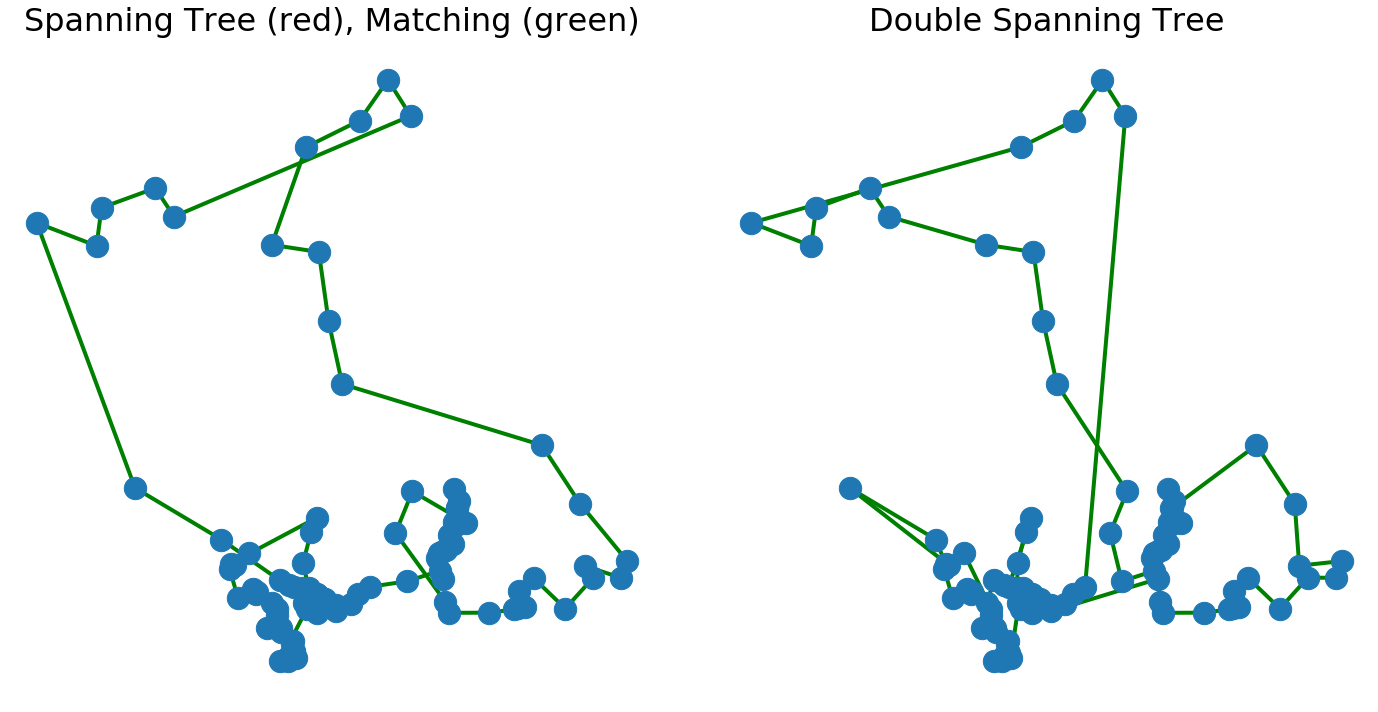

4901.185132591991
5519.939715105946
[ 0 12  1 14  8  4  6  2 11 13  9  7  5  3 10  0]


In [5]:
# points = [[0.2,0], [0.8,0], [0,1], [1,1], [0.5,1.6]]
# points = np.genfromtxt('../datasets/p01_xy.txt', delimiter=' ')
points = np.genfromtxt('../datasets/bc100_xy.csv', delimiter=',')

n = len(points)
A = np.zeros((n,n))
for i in range(0, n):
    for j in range(0, n):
        a = np.matrix(points[i])
        b = np.matrix(points[j])
        A[i][j] = np.linalg.norm(a-b)


opt_tour1, mst1, matching = chriSerd(A)
opt_tour2, mst2 = doubleSpanTree(A)
np.random.seed(7979)
G = nx.from_numpy_matrix(np.matrix(A))
G_pos = dict(zip(range(0,n),points))

edgeLabels = {}
for edge in G.edges.data():
    uv = (edge[0], edge[1])
    weight = edge[2]['weight']
    edgeLabels[uv] = np.round(weight, 2)


    
# load NN and NI tours from csv
tour_seq1 = np.genfromtxt('NN-and-NI/100city_neighbour.csv', delimiter=',', dtype=int)-1
tour_seq2 = np.genfromtxt('NN-and-NI/100city_insertion.csv', delimiter=',',dtype=int)-1
print(tour_seq1)


# build the matrix for the optimal tour graph
# opt_tour_G1, opt_tour_matrix1 = buildTourGraph(opt_tour1)
# opt_tour_G2, opt_tour_matrix2 = buildTourGraph(opt_tour2)

opt_tour_G1, opt_tour_matrix1 = buildTourGraph(tour_seq1)
opt_tour_G2, opt_tour_matrix2 = buildTourGraph(tour_seq2)
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
axs[0].set_title('Spanning Tree (red), Matching (green)', fontsize=32)
axs[1].set_title('Double Spanning Tree', fontsize=32)
axs[0].axis('off')
axs[1].axis('off')
nodeSize=500
# Subplot 1 draw G and edge weights
nx.draw_networkx_nodes(G, pos=G_pos,
                        ax=axs[0],
                        font_size=30,
                        node_size=nodeSize,
                        with_labels=True,
                        connectionstyle='arc3, rad = 0.3')
# nx.draw_networkx_edge_labels(G, pos=G_pos, edge_labels=edgeLabels,ax=axs[0], font_size=25)

# draw Tour Chris
# nx.draw_networkx_edges(mst1,
#                 pos=G_pos, 
#                 connectionstyle='arc3, rad = 0.3',
#                 edgelist=mst1.edges,
#                 edge_color='r', 
#                 width=4, 
#                 ax=axs[0], 
#                 with_labels=False)

# nx.draw_networkx_edges(nx.DiGraph(G),
#                        pos=G_pos, 
#                        connectionstyle='arc3, rad = 0.3',
#                        edgelist=matching, 
#                        edge_color='g', 
#                        width=4, ax=axs[0])

nx.draw_networkx_edges(opt_tour_G1,
                       pos=G_pos, 
                       connectionstyle='arc3, rad = 0.1',
                       edge_color='g', 
                       width=4, ax=axs[0])

# Subplot 2 draw G and edge weights
nx.draw_networkx_nodes(G, pos=G_pos, ax=axs[1], font_size=30, node_size=nodeSize)

# nx.draw_networkx_edge_labels(G, pos=G_pos, edge_labels=edgeLabels,ax=axs[1], font_size=25)

# draw Tour Double MSP
nx.draw_networkx_edges(opt_tour_G2, 
                       pos=G_pos,
                       edge_color='g',
                       width=4, ax=axs[1],
                       with_labels=False)

# nx.draw_networkx_edges(nx.DiGraph(mst2), 
#                        pos=G_pos,
#                        edge_color='r',
#                        width=4,
#                        ax=axs[1],
#                        connectionstyle='arc3, rad = 0.1')
fig.tight_layout()
print(mst2.edges)
plt.show()

cost1 = np.sum(np.multiply(opt_tour_matrix1, A))
cost2 = np.sum(np.multiply(opt_tour_matrix2, A))
print(cost1)
print(cost2)
true_tour = np.array([1,13,2,15,9,5,7,3,12,14,10,8,6,4,11,1])-1
print(true_tour)
# true_tour_G, true_tour_matrix = buildTourGraph(n, true_tour)
# min_cost = np.sum(np.multiply(true_tour_matrix, A))
# print(min_cost)

In [15]:
from numpy import genfromtxt
A = genfromtxt('../datasets/bc_distance_matrix.csv', delimiter=',')
opt_tour1, mst1, matching = chriSerd(A)
opt_tour2, mst2 = doubleSpanTree(A)
# build the matrix for the optimal tour graph
n = np.shape(A)[0]
opt_tour_G1, opt_tour_matrix1 = buildTourGraph(opt_tour1)
opt_tour_G2, opt_tour_matrix2 = buildTourGraph(opt_tour2)
cost1 = np.sum(np.multiply(opt_tour_matrix1, A))
cost2 = np.sum(np.multiply(opt_tour_matrix2, A))
print(cost1, cost2)

df = pd.read_csv('../datasets/bc_city_data.csv',delimiter=',',sep='\n' )

CS_title = 'Christofides-Serdyukov approx optimal route'
DMST_tile = 'Double MST optimal route'
NN_title = "Nearest Neighbor optimal route"
NI_title = "Nearest Insertion optimal route"

NN_tour = np.genfromtxt('NN-and-NI/100city_neighbour.csv', delimiter=',', dtype=int)-1
NI_tour = np.genfromtxt('NN-and-NI/100city_insertion.csv', delimiter=',', dtype=int)-1

route_lats_CS = df.iloc[opt_tour1]['lat']
route_lng_CS = df.iloc[opt_tour1]['lng']

route_lats_dmst = df.iloc[opt_tour2]['lat']
route_lng_dmst = df.iloc[opt_tour2]['lng']

route_lats_NI = df.iloc[NI_tour]['lat']
route_lng_NI = df.iloc[NI_tour]['lng']

route_lats_NN = df.iloc[NN_tour]['lat']
route_lng_NN = df.iloc[NN_tour]['lng']


Christofides.  cost:  4679.449032682213 , optimal tour: [4, 10, 3, 18, 1, 19, 7, 27, 34, 16, 8, 15, 23, 6, 14, 67, 66, 96, 51, 26, 74, 73, 79, 83, 63, 87, 62, 54, 69, 33, 71, 81, 64, 90, 85, 36, 94, 75, 72, 20, 56, 89, 46, 92, 5, 28, 88, 68, 65, 11, 53, 58, 17, 78, 45, 31, 98, 84, 93, 70, 41, 61, 48, 80, 25, 30, 42, 43, 82, 37, 59, 97, 47, 12, 95, 60, 29, 21, 50, 52, 40, 9, 55, 35, 2, 38, 24, 39, 76, 44, 91, 57, 77, 86, 22, 32, 49, 99, 13, 0, 4]
Double Min Span Tree optimal tour: [4, 10, 0, 3, 18, 1, 19, 7, 27, 34, 16, 8, 15, 23, 6, 14, 67, 66, 96, 51, 26, 74, 73, 79, 83, 63, 87, 62, 54, 69, 33, 64, 90, 85, 71, 81, 68, 88, 28, 5, 92, 46, 56, 20, 72, 75, 94, 36, 89, 65, 11, 53, 58, 17, 78, 84, 98, 31, 45, 93, 70, 41, 61, 48, 13, 22, 86, 77, 57, 12, 95, 60, 29, 21, 50, 52, 40, 9, 55, 24, 39, 76, 44, 38, 2, 35, 91, 47, 97, 59, 37, 82, 30, 25, 80, 42, 43, 32, 49, 99, 4]
4679.449032682213 5661.319907113176


In [21]:
px.set_mapbox_access_token(open("plotly-key").read())
df = pd.read_csv('../datasets/bc_city_data.csv')
df.head
fig = px.scatter_mapbox(df, 
                        lat="lat",
                        lon="lng",
                        color_continuous_scale=px.colors.cyclical.IceFire, 
                        size_max=20)

# CS trace
# fig.add_trace(go.Scattermapbox(
#     mode = "markers+lines",
#     lon = route_lng_CS,
#     lat = route_lats_CS,
#     name=CS_title,
#     marker = {'size': 10}))

# NN trace
# fig.add_trace(go.Scattermapbox(
#     mode = "markers+lines",
#     lon = route_lng_NN,
#     lat = route_lats_NN,
#     name=NN_title,
#     marker = {'size': 10}))

# NI trace
# fig.add_trace(go.Scattermapbox(
#     mode = "markers+lines",
#     lon = route_lng_NI,
#     lat = route_lats_NI,
#     name=NI_title,
#     marker = {'size': 8}))

# DMST trace
fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = route_lng_dmst,
    lat = route_lats_dmst,
    name=DMST_tile,
    marker = {'size': 10}))

fig.update_layout(
    autosize=False,
    width=1920,
    height=1080,
    hovermode='closest',
    mapbox=dict(
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=52.5,
            lon=-122.8489
        ),
        pitch=0,
        zoom=5.4
    )
)

fig.show()
fig.write_image('cs-map.png')


In [ ]:
import math
lat1=52.5
lon1=-122.8489

def ll_xy(lat, lon, lat0, lon0):
    dx = (lon0-lon)*40000*math.cos((lat0+lat)*math.pi/360)/360
    dy = (lat0-lat)*40000/360
    return -dx, -dy

# for i in range(0, len())
lat = np.array(df.iloc[:,4])
long = np.array(df.iloc[:,5])

points = []
for i in range(0,len(lat)):
    points.append(ll_xy(lat[i], long[i], lat1, lon1))
              
n = len(points)
A = np.zeros((n,n))
for i in range(0, n):
    for j in range(0, n):
        a = np.matrix(points[i])
        b = np.matrix(points[j])
        A[i][j] = np.linalg.norm(a-b)

# np.savetxt("../datasets/bc100_xy.csv", points, delimiter=",")


In [ ]:
opt_tour_edgeList1